In [11]:
from mozo import my_train_test_split, train_and_submit, merge_with_features, from_ln_pln_trans_to_predict, num_to_range_categories, my_train_test_split, save_model, stratified_sample

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
#%matplotlib inline

import math

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)


from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from sklearn.svm import SVC

from sklearn.metrics import r2_score, f1_score, mean_absolute_error, mean_squared_error

from scikitplot.estimators import plot_learning_curve

import time
from datetime import datetime
from threading import Timer



In [2]:
import pandas as pd
train = pd.read_hdf('~/pml7/module3/input/train.car_price.h5')
test = pd.read_hdf('~/pml7/module3/input/test.car_price.h5') #zbiór testowy bez odpowiedzi

In [3]:
train, test = merge_with_features('ft_price_test.csv', train, test)

train, test = merge_with_features('ft_created_at_unix_train.csv', train, test)
train, test = merge_with_features('ft_latitude_longitude_train.csv', train, test)

train, test = merge_with_features('ft_new_param_test.csv', train, test)
train, test = merge_with_features('ft_new_param_2_encoded_train.csv', train, test)
train, test = merge_with_features('ft_new_param_3_encoded_train.csv', train, test)

train, test = merge_with_features('ft_range_param_encoded_train.csv', train, test)

train, test = merge_with_features('ft_mca_test.csv', train, test)
train, test = merge_with_features('ft_pca_train.csv', train, test)


train
Index(['car_id', 'pln_to_eur', 'price_value_pln',
       'price_value_pln_log_transl'],
      dtype='object')
test
Index(['car_id', 'pln_to_eur'], dtype='object')
train
Index(['car_id', 'created_at_unix', 'created_at_unix_na_mean'], dtype='object')
test
Index(['car_id', 'created_at_unix', 'created_at_unix_na_mean'], dtype='object')
train
Index(['car_id', 'latitude', 'latitude_na_mean', 'longitude',
       'longitude_na_mean'],
      dtype='object')
test
Index(['car_id', 'latitude', 'latitude_na_mean', 'longitude',
       'longitude_na_mean'],
      dtype='object')
train
Index(['car_id', 'new_param_rok-produkcji',
       'new_param_rok_produkcji_minus_aktualny_rok',
       'new_param_pierwsza-rejestracja-date', 'new_param_przebieg',
       'new_param_moc', 'new_param_pojemność-skokowa',
       'new_param_liczba-drzwi', 'new_param_liczba-miejsc',
       'new_param_serwisowany-w-aso', 'new_param_pierwszy-właściciel',
       'new_param_bezwypadkowy', 'new_param_zarejestrowany-w-polsc

train
Index(['car_id', 'encoded_seller_type', 'encoded_seller_name',
       'encoded_seller_address', 'encoded_new_param_marka_pojazdu',
       'new_param_marka-pojazdu', 'encoded_new_param_model_pojazdu',
       'new_param_model', 'encoded_new_param_wersja_pojazdu',
       'new_param_wersja', 'encoded_new_param_kod_silnika',
       'new_param_kod-silnika'],
      dtype='object')
test
Index(['car_id', 'encoded_seller_type', 'encoded_seller_name',
       'encoded_seller_address', 'encoded_new_param_marka_pojazdu',
       'new_param_marka-pojazdu', 'encoded_new_param_model_pojazdu',
       'new_param_model', 'encoded_new_param_wersja_pojazdu',
       'new_param_wersja', 'encoded_new_param_kod_silnika',
       'new_param_kod-silnika'],
      dtype='object')
train
Index(['car_id', 'range_new_param_rok_produkcji_cat',
       'encoded_range_new_param_rok_produkcji_cat',
       'range_new_param_przebieg_cat', 'encoded_range_new_param_przebieg_cat',
       'range_new_param_moc_cat', 'encoded_r

In [ ]:
test

# pomysly:
- startyfikacja
- waznosc cech
- zapomiane zmienne jak: EUR/PLN, Mazowieckie, 
- encodowanie -1 braków - zamiast sredniej, zera
- z bonusu waznosc kombijacji cech
- kombinacje na featurach
- kombinacje na innych
- hiper tuning
- w xgboost metryka uczenia log
- bread ???
- sztuczne zmienne jak trend ?

# Stratyfikacja:
- 

In [4]:
#train_30['car_id'].to_csv('output/split_train_30.csv', index=False) 
train_30 = pd.read_csv('~/pml7/konkurs/output/split_train_30.csv')
train_30

,car_id
0,45094
1,130753
2,36910
3,25469
4,8466
...,...
31966,62164
31967,77625
31968,83308
31969,115613


# modele - próby

In [ ]:
vars_main = [ 
             #'created_at_unix_na_mean', 
             'latitude_na_mean', 'longitude_na_mean', 
             'new_param_rok-produkcji', 
             'new_param_rok_produkcji_minus_aktualny_rok', 
             'new_param_pierwsza-rejestracja-date',
            'new_param_przebieg', 'new_param_moc', 'new_param_pojemność-skokowa', 
             'new_param_liczba-drzwi', 'new_param_liczba-miejsc',
           ]

vars_features = [col for col in train if col.startswith('feature_')]

vars_bool_params = ['new_param_serwisowany-w-aso', 'new_param_pierwszy-właściciel', 'new_param_bezwypadkowy',
                'new_param_zarejestrowany-w-polsce', 'new_param_uszkodzony', 
                'new_param_leasing-concession', 'new_param_możliwość-finansowania',
                'new_param_filtr-cząstek-stałych',
                'new_param_metalik', 'new_param_perłowy', 'new_param_akryl-(niemetalizowany)'
                   ]

vars_new_params_2 = [
    'encoded_new_param_typ', #'new_param_typ', 
              
    'encoded_new_param_kraj_pochodzenia', #'new_param_kraj_pochodzenia_2', 
    #'new_param_kraj_pochodzenia_Polska', 'new_param_kraj_pochodzenia_Niemcy', 'new_param_kraj_pochodzenia_Francja',     'new_param_kraj_pochodzenia_Belgia', 'new_param_kraj_pochodzenia_Szwajcaria', 'new_param_kraj_pochodzenia_Holandia',     'new_param_kraj_pochodzenia_Stany_Zjednoczone', 'new_param_kraj_pochodzenia_Włochy', 'new_param_kraj_pochodzenia_Austria',     'new_param_kraj_pochodzenia_Wielka_Brytania', 'new_param_kraj_pochodzenia_Dania', 'new_param_kraj_pochodzenia_Szwecja',     'new_param_kraj_pochodzenia_Luksemburg', 'new_param_kraj_pochodzenia_Kanada', 'new_param_kraj_pochodzenia_Czechy',      'new_param_kraj_pochodzenia_Hiszpania', 
    #'new_param_kraj_pochodzenia_Inny',
    
    'encoded_new_param_rodzaj_paliwa', #'new_param_rodzaj_paliwa_2',
    #'new_param_rodzaj_paliwa_Diesel', 'new_param_rodzaj_paliwa_Benzyna', 'new_param_rodzaj_paliwa_Benzyna_LPG',     'new_param_rodzaj_paliwa_Benzyna_CNG', 'new_param_rodzaj_paliwa_Hybryda', 'new_param_rodzaj_paliwa_Elektryczny',
    
    'encoded_new_param_skrzynia_biegów', #'new_param_skrzynia_biegów_2',  
    #'new_param_skrzynia_biegów_Manualna', 'new_param_skrzynia_biegów_Półautomatyczna', 'new_param_skrzynia_biegów_Automatyczna_hydrauliczna',     'new_param_skrzynia_biegów_Automatyczna_dwusprzęgłowa', 'new_param_skrzynia_biegów_Automatyczna_bezstopniowa',
    
    'encoded_new_param_napęd', #'new_param_napęd_2', 
    #'new_param_napęd_Na_przednie_koła', 'new_param_napęd_4x4_stały', 'new_param_napęd_4x4_dołączany_automatycznie',     'new_param_napęd_4x4_dołączany_ręcznie', 'new_param_napęd_Na_tylne_koła', 
              
    'encoded_new_param_kolor', #'new_param_kolor_2', 
    #'new_param_kolor_Beżowy',  'new_param_kolor_Biały',  'new_param_kolor_Bordowy',  'new_param_kolor_Brązowy',  'new_param_kolor_Czarny',  'new_param_kolor_Czerwony',  'new_param_kolor_Fioletowy',  'new_param_kolor_Inny kolor',  'new_param_kolor_Niebieski',  'new_param_kolor_Srebrny',  'new_param_kolor_Szary',  'new_param_kolor_Zielony',  'new_param_kolor_Złoty',  'new_param_kolor_Żółty', 
]

vars_new_params_3 = [
    'encoded_seller_type', 'encoded_seller_address', #'encoded_seller_name', 
              
    'encoded_new_param_marka_pojazdu', #'new_param_marka-pojazdu',
    'encoded_new_param_model_pojazdu', #'new_param_model',
    'encoded_new_param_wersja_pojazdu', #'new_param_wersja',
    'encoded_new_param_kod_silnika', #'new_param_kod-silnika',
             ]

vars_bool_years = [
           #'new_param_pierwsza_rejestracja_ten_rok', 'new_param_pierwsza_rejestracja_poprzedni_rok', 'new_param_pierwsza_rejestracja_2_lata', 'new_param_pierwsza_rejestracja_3_lata',
           #'new_param_pierwsza_rejestracja_4_5_lat', 'new_param_pierwsza_rejestracja_6_7_lat', 'new_param_pierwsza_rejestracja_8_10_lat', 'new_param_pierwsza_rejestracja_11_15_lat', 'new_param_pierwsza_rejestracja_16_wiecej_lat',
           
           'new_param_rok-produkcji_ten_rok', 'new_param_rok-produkcji_poprzedni_rok', 'new_param_rok-produkcji_2_lata', 'new_param_rok-produkcji_3_lata',
           'new_param_rok-produkcji_4_5_lat', 'new_param_rok-produkcji_6_7_lat', 'new_param_rok-produkcji_8_10_lat', 'new_param_rok-produkcji_11_15_lat', 'new_param_rok-produkcji_16_wiecej_lat',
]

vars_mca = [col for col in train if col.startswith('mca_')]
vars_pca = [col for col in train if col.startswith('pca_')]


filter_col = [ 'car_id',
              #*vars_main, 
              #*vars_features,  
              ##*vars_bool_params,
              ##*vars_new_params_2,
              ##*vars_new_params_3,
              ##*vars_bool_years,
              #*vars_mca,
              *vars_pca,
             ] 


# print(train[filter_col].describe())
print(train[filter_col].info())
print(test[filter_col].info())
# (test[filter_col].head())

feats = test.select_dtypes(include=[np.number, np.bool]).columns
feats = feats[ feats != 'car_id' ].values
feats

In [5]:
filter_col = [
        "car_id",
        "encoded_new_param_kod_silnika",
        "encoded_new_param_kolor",
        "encoded_new_param_kraj_pochodzenia",
        "encoded_new_param_marka_pojazdu",
        "encoded_new_param_model_pojazdu",
        "encoded_new_param_napęd",
        "encoded_new_param_rodzaj_paliwa",
        "encoded_new_param_skrzynia_biegów",
        "encoded_new_param_typ",
        "encoded_new_param_wersja_pojazdu",
        "encoded_seller_address",
        "encoded_seller_type",
        "latitude_na_mean",
        "longitude_na_mean",
        "new_param_akryl-(niemetalizowany)",
        "new_param_bezwypadkowy",
        "new_param_filtr-cząstek-stałych",
        "new_param_liczba-drzwi",
        "new_param_liczba-miejsc",
        "new_param_metalik",
        "new_param_moc",
        "new_param_możliwość-finansowania",
        "new_param_perłowy",
        "new_param_pierwsza-rejestracja-date",
        "new_param_pierwszy-właściciel",
        "new_param_pojemność-skokowa",
        "new_param_przebieg",
        "new_param_rok-produkcji",
        "new_param_rok-produkcji_11_15_lat",
        "new_param_rok-produkcji_16_wiecej_lat",
        "new_param_rok-produkcji_2_lata",
        "new_param_rok-produkcji_3_lata",
        "new_param_rok-produkcji_4_5_lat",
        "new_param_rok-produkcji_6_7_lat",
        "new_param_rok-produkcji_8_10_lat",
        "new_param_rok-produkcji_poprzedni_rok",
        "new_param_rok-produkcji_ten_rok",
        "new_param_rok_produkcji_minus_aktualny_rok",
        "new_param_serwisowany-w-aso",
        "new_param_uszkodzony",
        "new_param_zarejestrowany-w-polsce",
        "pca_0",
        "pca_1",
        "pca_10",
        "pca_11",
        "pca_12",
        "pca_14",
        "pca_15",
        "pca_16",
        "pca_17",
        "pca_19",
        "pca_2",
        "pca_20",
        "pca_22",
        "pca_23",
        "pca_24",
        "pca_25",
        "pca_26",
        "pca_27",
        "pca_28",
        "pca_29",
        "pca_3",
        "pca_30",
        "pca_31",
        "pca_32",
        "pca_33",
        "pca_34",
        "pca_35",
        "pca_36",
        "pca_37",
        "pca_38",
        "pca_39",
        "pca_4",
        "pca_5",
        "pca_6",
        "pca_8",
        "pca_9"
    ]

In [15]:
best_params =  {
    'n_estimators': 90, #879, 
    #'n_estimators': 879, 
    'learning_rate': 0.1, #0.017354274677292683, 
    #'learning_rate': 0.017354274677292683, 

    'subsample': 0.923403370465418,
    'colsample_bytree': 0.8797393544001986, 

    'max_depth': 7, #43, 
    #'max_depth': 43, 
    'min_child_weight': 100, #48, 
    #'min_child_weight': 48, 
    
    'reg_alpha': 1.1048264246167496, 
    'reg_lambda': 0.7451037079565321, 

    'random_state': 6950, 
    
}

#model = ctb.CatBoostRegressor(n_estimators=100, depth=10, random_state=3400, verbose=False)
#model = RandomForestRegressor(max_depth=10, n_estimators=150, max_features=0.8)
model = xgb.XGBRegressor(**best_params)

In [16]:
X_train, X_test, y_train, y_test = my_train_test_split(train[filter_col], train['price_value_pln_log_transl'], train_30)
#X_train, X_test, y_train, y_test = train_test_split(train[filter_col], train['price_value_pln_log_transl'], test_size=0.3)
#X_test.head()

11448.05216165756
0.7857602158556327


(11448.05216165756, 0.7857602158556327)

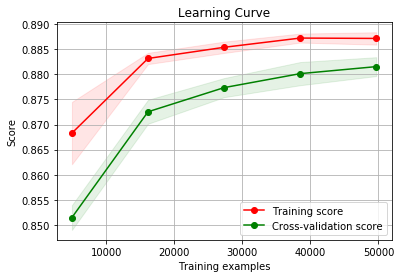

In [19]:
train_and_submit(X_train, X_test, y_train, y_test, model, best_params,
                     file_sufix= 'z_funkcji', opis='testuje rozne n_estimators',
                     do_plot = True, save_min=7000,
                     kaggle=False, kaggle_min=5000) 

In [ ]:
import random
min_mae = 99999

kaggle_c = 0
kaggle_mae_min = 5000

len_filter_col = len(filter_col)

while True:
#     random_features = list(np.unique(['car_id', 'latitude_na_mean', 'longitude_na_mean', 
#                                       'encoded_seller_type', 'new_param_rok_produkcji_minus_aktualny_rok', 
#                                       'new_param_przebieg', 'new_param_moc', 'new_param_pojemność-skokowa', 
#                                       'pca_0', 'pca_1', 'pca_2', 'pca_3']
#               + list(np.random.choice(filter_col, size=len_filter_col, replace=True))))

    diffference = Diff( filter_col, list(np.random.choice(filter_col, size=random.randint(5, 25), replace=True)) )
    random_features = list(np.unique(['car_id'] + diffference))
                           
    print(len(random_features))
#     print(random_features)
    print(min_mae)

    mae = train_and_submit(random_features, kaggle=(kaggle_c < 3), kaggle_min=kaggle_mae_min)

    if mae < kaggle_mae_min:  
        kaggle_c += 1

    if min_mae > mae: 
        min_mae = mae
        print(mae)
                           

In [ ]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        #'n_estimators': int(space['n_estimators']),
        'n_estimators': 800,
        'colsample_bytree': space['colsample_bytree'],
        #'learning_rate': space['learning_rate'],
        'learning_rate': 0.1,
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'objective': 'reg:squarederror',
        'random_state': 3400,
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('max_depth', 1, 100, 1),
    #'n_estimators': hp.quniform ('n_estimators', 1, 1000, 1),
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.1, 1.),
    #'learning_rate': hp.uniform ('learning_rate', 0.01, 1.0),
    'subsample': hp.uniform ('subsample', 0.01, 1.),
    'random_state': hp.quniform ('random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 100, 1),
    'reg_alpha': hp.loguniform ('reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('reg_lambda', 0.1, 1.),
}


In [ ]:
time_hyper_tuning_start = datetime.now().strftime("%H:%M:%S")

X_train, X_test, y_train, y_test = train_test_split(train[filter_col],
                                                    train[], test_size=0.3)

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=100,
            trials=trials)

best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['random_state'] = int(best_params['random_state'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])

print("The best params: ", best_params)
time_hyper_tuning_end = datetime.now().strftime("%H:%M:%S")


100%|██████████| 100/100 [2:58:45<00:00, 107.26s/trial, best loss: 0.2096486593862239]  
The best params:  {'colsample_bytree': 0.8797393544001986, 'learning_rate': 0.017354274677292683, 'max_depth': 43, 'min_child_weight': 48, 'n_estimators': 879, 'random_state': 6950, 'reg_alpha': 1.1048264246167496, 'reg_lambda': 0.7451037079565321, 'subsample': 0.923403370465418}


In [ ]:
print(879 / 0.017354274677292683)
print(88 / 0.0017354274677292683)
print(50 / 0.3)
print(2000 / 0.01)

In [ ]:
test.columns

In [ ]:
test

In [ ]:
import pandas as pd
import numpy as np
#np.random.seed(0)

import xgboost as xgb

train2 = pd.read_hdf('~/pml7/module3/input/train.car_price.h5')
test2 = pd.read_hdf('~/pml7/module3/input/test.car_price.h5') #zbiór testowy bez odpowiedzi

feats = test2.select_dtypes(include=[np.number, np.bool]).columns
feats = feats[ feats != 'car_id' ].values

X_train = train2[ feats ].values
y_train = train2['price_value'].values

xgb_params = {    
    'max_depth': 10, 
    'n_estimators': 50, 
    'learning_rate': 0.3, 
    'subsample': 0.5, 
    'colsample_bytree': 0.9,
}

model = xgb.XGBRegressor(**xgb_params)
model.fit(X_train, y_train)

## predict
X_test = test2[feats].values
y_pred = model.predict(X_test)

global_min = train.price_value.min()
y_pred[ y_pred < global_min] = global_min

test2['price_value'] = y_pred

#prepare to submit
save_model('car_price_simble_xgb', train2, test2, feats, model,
                                    details = {"mean_absolute_error" : -1, "r2_score" : -1, "vars": feats, 
                                               "best_params" : xgb_params,
                                    "opis" : "podany jako startowy"}, 
                                    kaggle=False)

In [ ]:
feats

In [18]:
def train_and_submit(X_train, X_test, y_train, y_test, model, best_params,
                     file_sufix= 'tas', opis='', do_plot = False, 
                     save_min=7000, kaggle=False, kaggle_min=5000):
    import pandas as pd
    import numpy as np

    time_model_start = datetime.now().strftime("%H:%M:%S")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test[X_test.columns[1:]]) #bez car_id

    y_test_org = from_ln_pln_trans_to_predict(X_test, y_test, train)
    y_pred_org = from_ln_pln_trans_to_predict(X_test, pd.DataFrame(y_pred), train)

    mae = mean_absolute_error(y_test_org, y_pred_org)
    r2 = r2_score(y_test_org, y_pred_org)
    print(mae)
    print(r2)

    if do_plot: 
        learning_curve = plot_learning_curve(model, X_train, y_train, cv=3, random_state=0, shuffle=True)
        #plt.hist(y_test_org - y_pred_org, bins=50);

    time_model_end = datetime.now().strftime("%H:%M:%S")

    if mae <= save_min:
        save_model(name=file_sufix, train_df=train, test_df=test, used_feats=X_train.columns, 
                                        my_model=model, mae=mae, r2=r2,
                                        details = {"mean_absolute_error" : mae, "r2_score" : r2, "vars": filter_col, 
                                                   "best_params" : best_params,
                                         #"tuning_start" : time_hyper_tuning_start, "tuning_end" : time_hyper_tuning_end, 
                                         "model_start" : time_model_start, "model_end" : time_model_end, 
                                        "opis" : opis}, 
                                        plot_learning_curve = learning_curve if do_plot else None, 
                                        #  plt_hist = plt if do_plot else None, #nie zadzialaja 2 wykresy :(
                                        kaggle=(kaggle and mae < kaggle_min))
    return mae, r2



11448.05216165756
0.7857602158556327


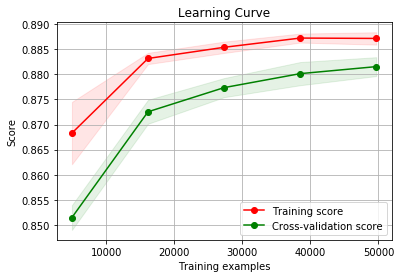

In [17]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test[X_test.columns[1:]]) #bez car_id

y_test_org = from_ln_pln_trans_to_predict(X_test, y_test, train)
y_pred_org = from_ln_pln_trans_to_predict(X_test, pd.DataFrame(y_pred), train)

mae = mean_absolute_error(y_test_org, y_pred_org)
r2 = r2_score(y_test_org, y_pred_org)
print(mae)
print(r2)

learning_curve = plot_learning_curve(model, X_train.values, y_train.values, cv=3, random_state=0, shuffle=True)
# plt.hist(y_test_org - y_pred_org, bins=50);


In [ ]:
def my_train_test_split(df_X, df_y, train_N):

    import pandas as pd
    
    df_total = pd.merge(df_X, df_y, left_index=True, right_index=True)
    test_car_ids = train_N['car_id'].values
    X = df_X.columns[1:] #bez car_id
    #print(X)
    y = df_y.name
    #print(y)
    
    df_train = df_total[~df_total['car_id'].isin(test_car_ids)]
    df_test = df_total[df_total['car_id'].isin(test_car_ids)]

    X_train = df_train[X]
    X_test = df_test[df_X.columns[0:]] #z car_id
    y_train = df_train[y]
    y_test = df_test[y]
    
    return X_train, X_test, y_train, y_test

#X_train, X_test, y_train, y_test = my_train_test_split(train[filter_col], train['price_value_pln_log_transl'], train_30)
#X_test

In [ ]:
X_test[['car_id']]

In [ ]:
X_train

In [ ]:
total = pd.concat([train, test], ignore_index=True)

In [ ]:
total.loc[111,'pca_0']

In [ ]:
X_test.loc[111,'pca_0']

In [ ]:
X_train.loc[111,'pca_0']